2.19.0
(X shape, y shape, every X's mean, every X's standard deviation)
(216, 30, 84) (40, 1) 0.5841828 0.11017553

The dataset has not been preprocessed, is not normalised etc
Iter #16:  Learning rate = 0.000100:  Batch Loss = 2.859972, Accuracy = 0.4375
PERFORMANCE ON TEST SET:          Batch Loss = 2.866611957550049, Accuracy = 0.25


Optimization Finished!
TOTAL TRAINING TIME: 51.74789762496948
Model saved in path: C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\weights\model.ckpt-1

--- Final Evaluation on Test Set (after training) ---
FINAL RESULT: Batch Loss = 2.0828194618225098, Accuracy = 0.5249999761581421


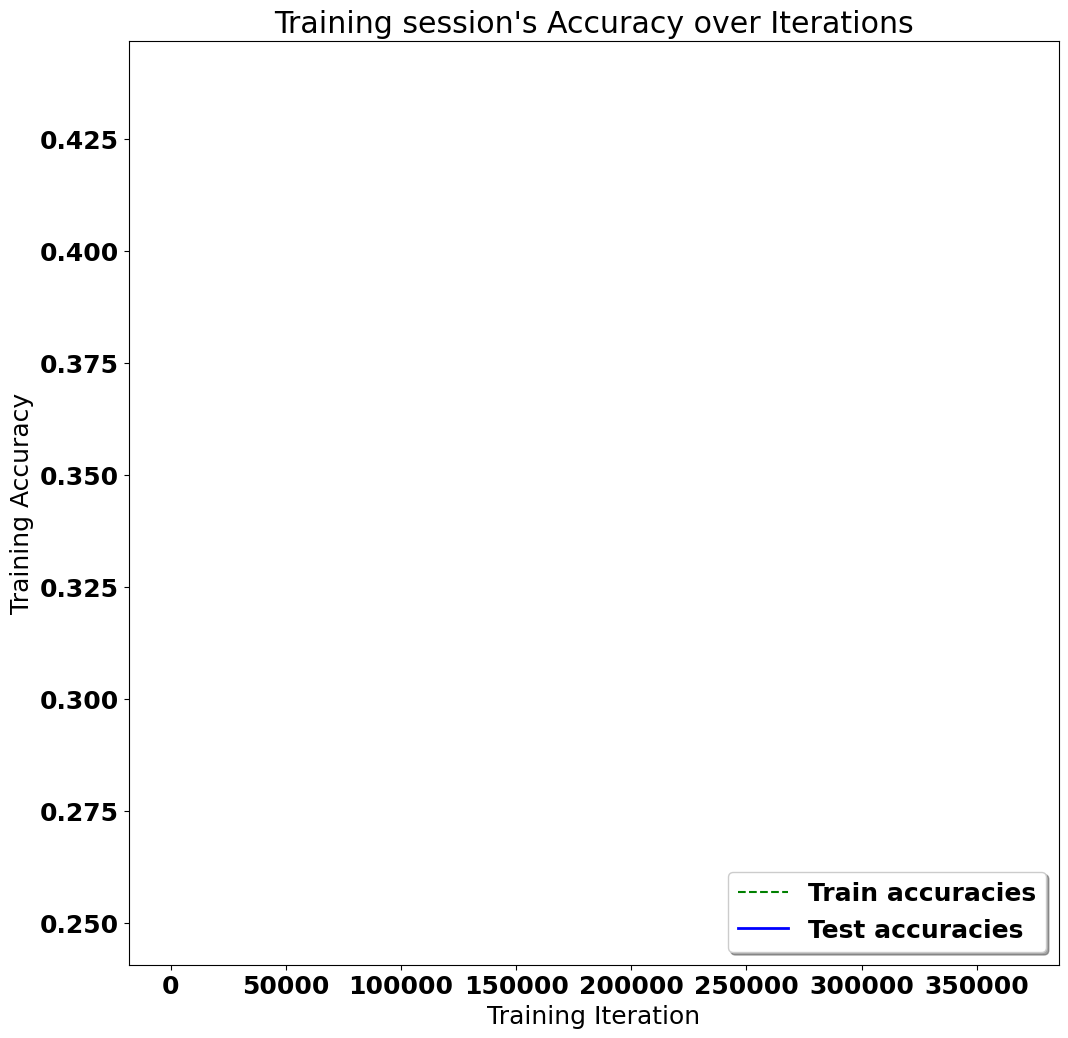

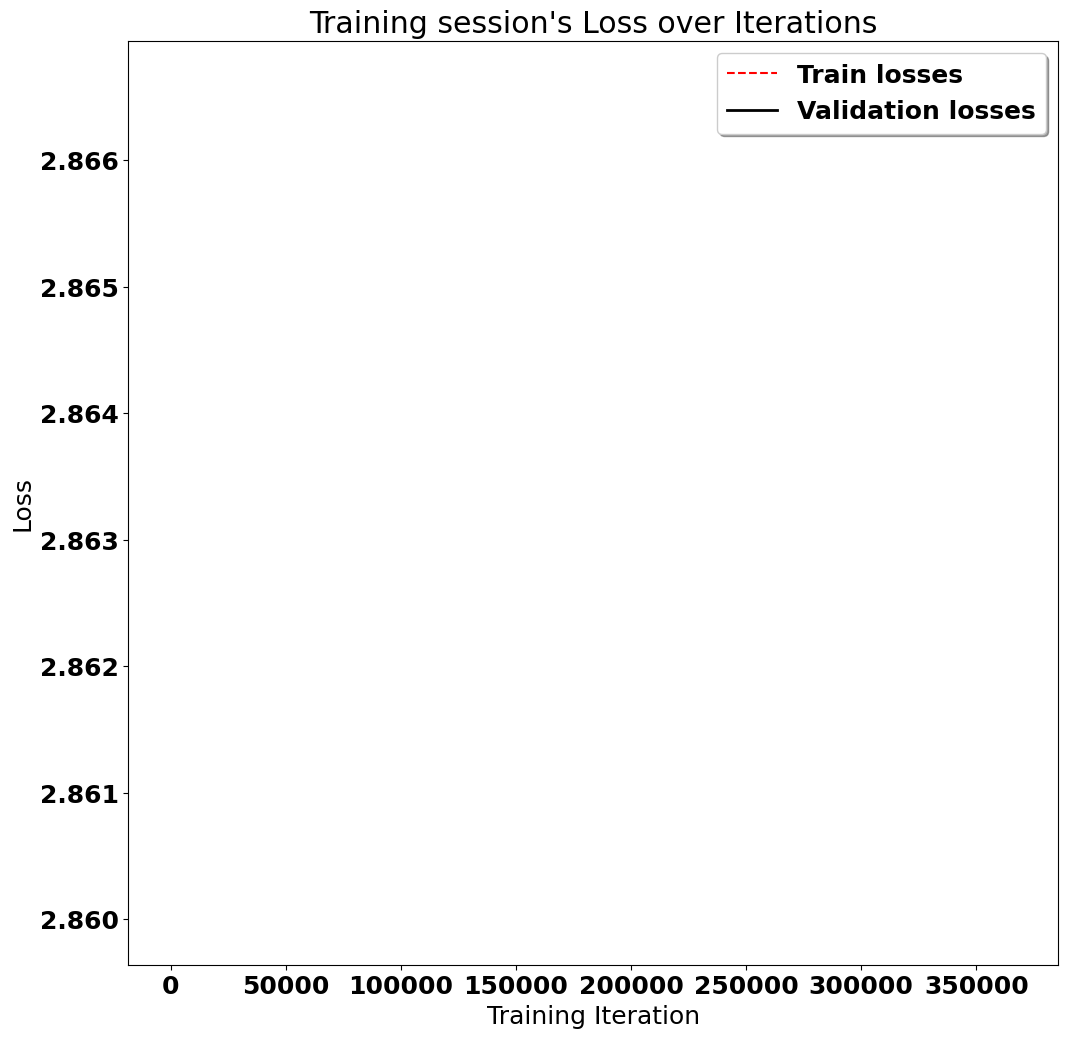


Confusion Matrix:
[[ 7  0  0  3]
 [ 6  4  0  0]
 [ 0  0  0 10]
 [ 0  0  0 10]]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
import random
import time
import os
import itertools
import matplotlib
matplotlib.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 18,
    "font.weight": "bold",
})


# --- データ読み込みとパラメータ設定 (元のコードから変更なし) ---

# Output classes to learn how to classify
LABELS = [
    "ageru",
    "understand",
    "annsinnsuru",
    "heavy"
]

# 学習データのパス
DATASET_PATH = "data/HAR_pose_activities/database/"
X_train_path = os.path.join(DATASET_PATH, "X_train.txt")
X_test_path = os.path.join(DATASET_PATH, "X_test.txt")
y_train_path = os.path.join(DATASET_PATH, "Y_train.txt")
y_test_path = os.path.join(DATASET_PATH, "Y_test.txt")

print(tf.__version__)

# モデルを保存するディレクトリ
MODEL_SAVE_PATH = r"C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\weights"
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

# データ読み込み関数
n_steps = 30

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]],
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    X_ = np.array(np.split(X_, blocks))
    return X_

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

# モデルのパラメータ設定
training_data_count = len(X_train)
test_data_count = len(X_test)
n_input = len(X_train[0][0])
n_hidden = 34
n_classes = 4

# 学習パラメータ
init_learning_rate = 0.0001
decay_rate = 0.96
decay_steps = 100000
lambda_loss_amount = 0.01
training_iters = training_data_count * 1700 # NOTE: 元のコードに合わせてイテレーション回数を設定
batch_size = 16
display_iter = batch_size * 10

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")

# バッチ作成とOne-hotエンコーディング関数 (元のコードから変更なし)
def extract_batch_size(_train, _labels, _unsampled, batch_size):
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size, 1))
    for i in range(batch_size):
        index = random.choice(_unsampled)
        batch_s[i] = _train[index]
        batch_labels[i] = _labels[index]
        _unsampled.remove(index)
    return batch_s, batch_labels, _unsampled

def one_hot(y_):
    y_ = y_.reshape(len(y_))
    n_values = n_classes
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]

# --- TensorFlow 2.x モデル定義 ---
# tf.keras.Modelを継承してモデルをクラスとして定義
class LSTM_RNN(tf.keras.Model):
    def __init__(self, n_input, n_hidden, n_classes):
        super(LSTM_RNN, self).__init__()
        # 元のコードの入力層の重みとバイアスに相当
        self.input_dense = tf.keras.layers.Dense(n_hidden, activation='relu')
        # TimeDistributedで各タイムステップに同じDense層を適用
        self.time_dist_dense = tf.keras.layers.TimeDistributed(self.input_dense)
        
        # 2層のLSTM
        self.lstm1 = tf.keras.layers.LSTM(n_hidden, return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(n_hidden)
        
        # 元のコードの出力層の重みとバイアスに相当
        self.out = tf.keras.layers.Dense(n_classes)

    def call(self, x):
        # フォワードパスを定義
        x = self.time_dist_dense(x)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.out(x)
        return x

# モデルのインスタンス化
model = LSTM_RNN(n_input, n_hidden, n_classes)

# 学習率の減衰スケジュール
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# オプティマイザ
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 損失関数 (logitsを入力とする)
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# 評価指標
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')


# --- カスタム学習ループのための関数 ---
# @tf.functionデコレータで処理を高速化
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as tape:
        predictions = model(batch_x, training=True)
        loss = loss_object(batch_y, predictions)
        # L2正則化を手動で損失に加える
        l2_loss = lambda_loss_amount * tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
        total_loss = loss + l2_loss
        
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(total_loss)
    train_accuracy(batch_y, predictions)

@tf.function
def test_step(test_x, test_y):
    predictions = model(test_x, training=False)
    t_loss = loss_object(test_y, predictions)
    # L2正則化もテスト損失に含める（元のコードの挙動を再現）
    l2_loss = lambda_loss_amount * tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
    total_loss = t_loss + l2_loss

    test_loss(total_loss)
    test_accuracy(test_y, predictions)
    return predictions


# --- モデル保存のためのCheckpointオブジェクトを作成 ---
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint_prefix = os.path.join(MODEL_SAVE_PATH, "model.ckpt")


# --- Plotting additions start ---
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
# --- Plotting additions end ---

# --- 学習セッション ---
step = 1
time_start = time.time()
unsampled_indices = list(range(0, len(X_train)))
X_test_tf = tf.constant(X_test, dtype=tf.float32)
y_test_one_hot_tf = tf.constant(one_hot(y_test), dtype=tf.float32)

while step * batch_size <= training_iters:
    if len(unsampled_indices) < batch_size:
        unsampled_indices = list(range(0, len(X_train)))
    
    batch_xs, raw_labels, unsampled_indices = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    
    batch_xs_tf = tf.constant(batch_xs, dtype=tf.float32)
    batch_ys_tf = tf.constant(batch_ys, dtype=tf.float32)

    train_step(batch_xs_tf, batch_ys_tf)

    if (step * batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        # --- Plotting additions start ---
        train_losses.append(train_loss.result().numpy())
        train_accuracies.append(train_accuracy.result().numpy())
        # --- Plotting additions end ---
        
        # ★★★ 修正点 ★★★
        # optimizer._decayed_lr(tf.float32) を lr_schedule(optimizer.iterations) に変更
        current_lr = lr_schedule(optimizer.iterations)
        print(f"Iter #{step * batch_size}:  Learning rate = {current_lr:.6f}:  "
              f"Batch Loss = {train_losses[-1]:.6f}, Accuracy = {train_accuracies[-1]}")
        
        # メトリクスをリセット
        train_loss.reset_state()
        train_accuracy.reset_state()

        # テストデータで評価
        test_step(X_test_tf, y_test_one_hot_tf)
        
        loss_test = test_loss.result().numpy()
        acc_test = test_accuracy.result().numpy()

        # --- Plotting additions start ---
        test_losses.append(loss_test)
        test_accuracies.append(acc_test)
        # --- Plotting additions end ---

        print(f"PERFORMANCE ON TEST SET:          Batch Loss = {loss_test}, Accuracy = {acc_test}")

        # メトリクスをリセット
        test_loss.reset_state()
        test_accuracy.reset_state()

    step += 1

    step += 1

print("Optimization Finished!")
time_stop = time.time()
print(f"TOTAL TRAINING TIME: {time_stop - time_start}")

# 学習が完了したモデルを保存
save_path = checkpoint.save(file_prefix=checkpoint_prefix)
print(f"Model saved in path: {save_path}")


# --- 学習直後のテストデータでの最終評価 ---
print("\n--- Final Evaluation on Test Set (after training) ---")
final_predictions = test_step(X_test_tf, y_test_one_hot_tf)
final_loss = test_loss.result().numpy()
final_accuracy = test_accuracy.result().numpy()

print(f"FINAL RESULT: Batch Loss = {final_loss}, Accuracy = {final_accuracy}")

# --- Plotting additions start (元のコードから変更なし) ---
font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')
plt.show()

# Lossのプロット
plt.figure(figsize=(width, height))
plt.plot(indep_train_axis, np.array(train_losses), "r--", label="Train losses")
plt.plot(indep_test_axis, np.array(test_losses), "k-", linewidth=2.0, label="Validation losses")
plt.title("Training session's Loss over Iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Loss')
plt.xlabel('Training Iteration')
plt.show()
# --- Plotting additions end ---

# 混同行列の表示
predictions = tf.argmax(final_predictions, axis=1).numpy()
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

print("\nConfusion Matrix:")
print(confusion_matrix)

